In [54]:
library(modelr)
library(tidyverse)
library(lubridate)
theme_set(theme_minimal())
options(repr.plot.width=6, repr.plot.height=4)

### Review problem
Use logistic regression to model the probability that a flight's departure delayed by more than one hour given the amount of precipitation that occurred that day.

- What is the predicted probability of delay if it doesn't rain at all?
- What is the predicted probability of delay if it rains an inch?

(Assume rain == precipitation)

Joining, by = c("year", "month", "day", "origin", "hour", "time_hour")


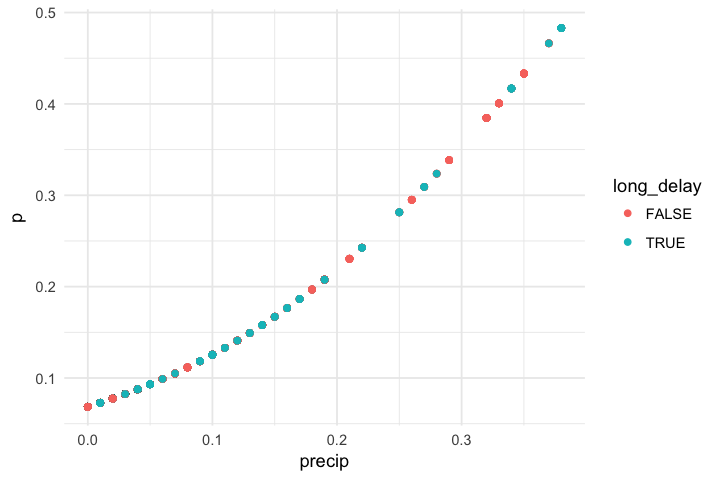

In [85]:
library(nycflights13)
df <- flights %>% mutate(long_delay = dep_delay > 60) %>% left_join(weather)
mdl <- glm(long_delay ~ precip, data = df, family = "binomial")
# summary(mdl)
df %>% add_predictions(mdl) %>% select(long_delay, precip, pred) %>% 
       mutate(p = 1 / (1 + exp(-pred))) %>% filter(!is.na(long_delay), !is.na(precip)) %>%
        ggplot + geom_point(aes(x=precip, y=p, color=long_delay))

# Lecture 21: Models for binary outcomes (logistic regression)

We pick up where we left off at the end of last week with studying logistic regression:

### Example: Image classification
We will use logistic regression to build an image classifier. We will train a model that recognizes the number 5.

In [86]:
load("../lecture20/mnist.RData")

The `mnist` table is a data frame with 60000 observations and 785 columns. Each row corresponds to a handwritten digit. The first column is the label of that image, and the next $784=28^2$ columns are pixel data for each image. 

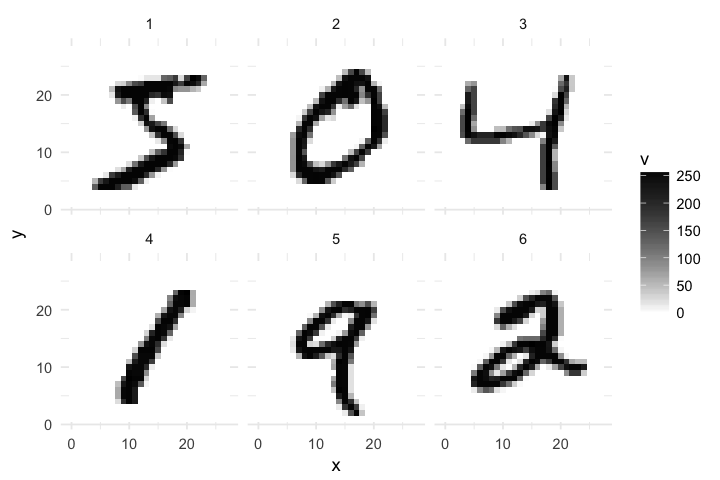

In [88]:
plot_images <- function(df) {
    df %>% mutate(i=row_number()) %>% 
    gather("k", "v", X2:X785) %>% mutate(px = as.numeric(str_sub(k, 2)) - 2,
                                         x = px %% 28,
                                         y = 28 - (px %/% 28)) %>% 
    ggplot() + geom_tile(aes(x=x, y=y, fill=v)) + facet_wrap(~ i) + 
    scale_fill_gradient(low="white", high="black")
}
mnist %>% slice(1:6) %>% plot_images

### Challenge problem
Use logistic regression to build an image classifier that tells whether or not the image is a "5".

In [89]:
train <- slice(mnist, 1:50000)
test <- slice(mnist, -(1:50000))

<img width=100 style="float:left; margin: 0 10px 0 0; " src="https://si.wsj.net/public/resources/images/OB-SS880_scream_DV_20120426110240.jpg"/> 

## My code is too slow!

Last lecture we saw that trying to use logistic regression on this data set made things too slow.
```{r}
glm(I(X1 == 5) ~ ., data = train)  # too slow
```

If we look back at the pictures, we see that a lot of the data columns a extraneous. For example:

In [59]:
summary(select(train, X2:X10))

       X2          X3          X4          X5          X6          X7   
 Min.   :0   Min.   :0   Min.   :0   Min.   :0   Min.   :0   Min.   :0  
 1st Qu.:0   1st Qu.:0   1st Qu.:0   1st Qu.:0   1st Qu.:0   1st Qu.:0  
 Median :0   Median :0   Median :0   Median :0   Median :0   Median :0  
 Mean   :0   Mean   :0   Mean   :0   Mean   :0   Mean   :0   Mean   :0  
 3rd Qu.:0   3rd Qu.:0   3rd Qu.:0   3rd Qu.:0   3rd Qu.:0   3rd Qu.:0  
 Max.   :0   Max.   :0   Max.   :0   Max.   :0   Max.   :0   Max.   :0  
       X8          X9         X10   
 Min.   :0   Min.   :0   Min.   :0  
 1st Qu.:0   1st Qu.:0   1st Qu.:0  
 Median :0   Median :0   Median :0  
 Mean   :0   Mean   :0   Mean   :0  
 3rd Qu.:0   3rd Qu.:0   3rd Qu.:0  
 Max.   :0   Max.   :0   Max.   :0  

This is a good moment to talk about *dimensionality reduction*. Nowadays we often find ourselves in a situation where there is too much data to do analysis. It can be useful to try and reduce the size of the data. The best-known method for dimensionality reduction is called Principle Components Analysis (PCA). 

In [90]:
pca <- prcomp(train[, 2:785], center=F, scale=F)

The idea of PCA is to find a more efficient way of representing our data. In particular, PCA will find new images that can be used to efficiently represent the original images. To better understand what this means,
let's look at some of those images:

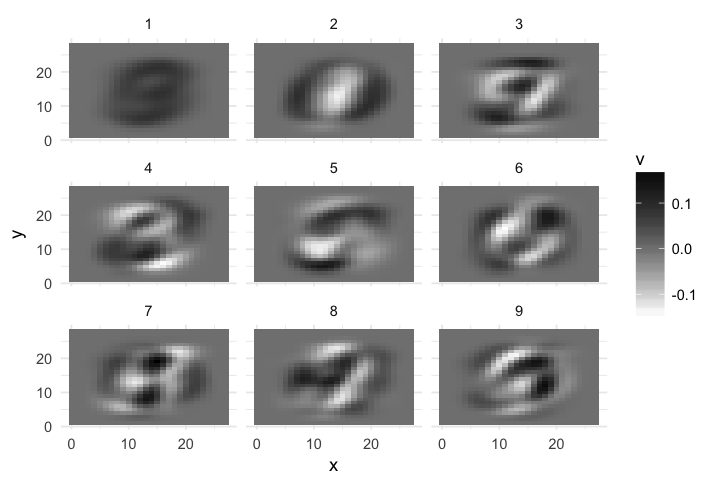

In [61]:
t(pca$rotation[,1:9]) %>% as_tibble %>% plot_images

These are the first nine principal components. We can write each of our (handwritten digits) as linear combination of these pictures -- literally adding them up.

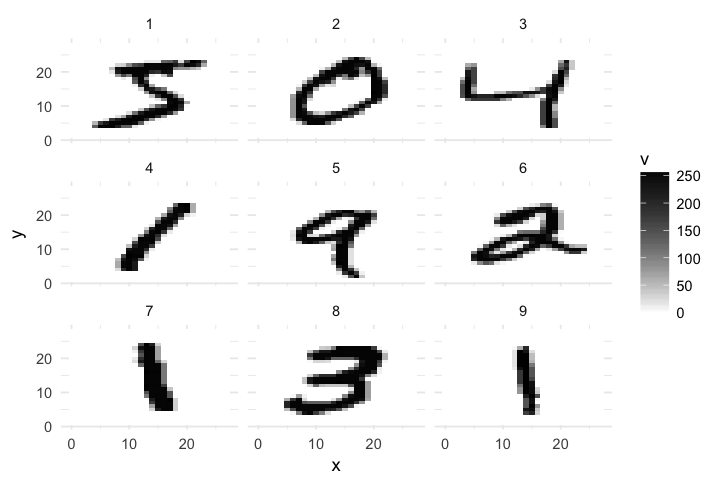

In [62]:
plot_images(train[1:9,])

By varying the number of principal components that we use to represent each image, we obtain progressively better results using less data:

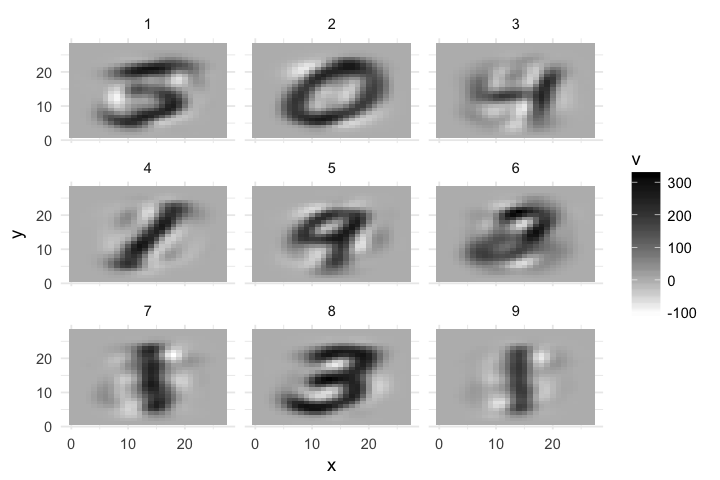

In [106]:
K <- 20  # Number of principal components
P <- pca$rotation[, 1:K]
projected = as_tibble(scale(train[, -1], pca$center, pca$scale) %*% P %*% t(P))
names(projected) <- names(train)[-1]
plot_images(projected[1:9, ])

Now let us see how dimensionality reduction has helped out when trying to fit the logistic regression. Instead of using the complete data set, we will only use the top $k$ principal components:

In [104]:
y <- train$X1 == 5
K <- 25 # Number of principal components
P <- pca$rotation[, 1:K]
X = scale(train[, -1], pca$center, pca$scale) %*% P
df <- as_tibble(X)
colnames(df) <- colnames(X)
df$y <- y
mdl <- glm(y ~ ., df, family="binomial")

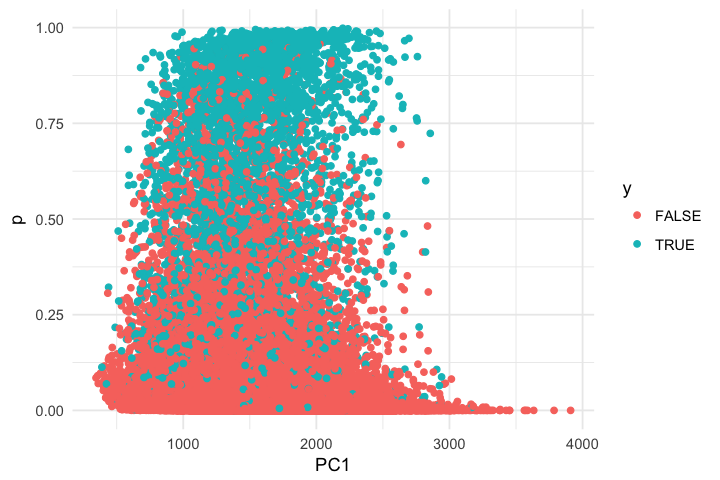

In [105]:
df %>% add_predictions(mdl) %>% mutate(p = plogis(pred)) %>%
    ggplot + geom_point(aes(x=PC1, y=p, colour=y))

## Test error
To test how well our model does, we will calculate its test error. Our measure of the error will be the (negative) log-likelihood of observing each observation under our model, defined as:

$$\text{loss} = -\sum_i y_i \log(\hat{p}_i) + (1 - y_i) \log(1-\hat{p}_i)$$

In [108]:
Xtest <- scale(test[, -1], pca$center, pca$scale) %*% P
df <- as_tibble(Xtest)
colnames(df) <- colnames(Xtest)
df$y <- test$X1 == 5
test_err <- df %>% add_predictions(mdl) %>% mutate(p = plogis(pred), 
                                                   error = -(y * log(p) + (1 - y) * log1p(-p)))
sum(test_err$error)

ERROR: Error in eval(predvars, data, env): object 'PC21' not found


### Challenge problem
Minimize the test error!

## Application: Cancer biology

The file `BC-TCGA.zip` contains gene expression measurements from cancer and normal patients in the [Cancer Genome Atlas](https://cancergenome.nih.gov/).

In [110]:
dir()
unzip("BC-TCGA.zip")
dir("BC-TCGA")

[1] "BC-TCGA"         "BC-TCGA.zip"     "brca.RData"      "Lecture21.ipynb"

[1] "BC-TCGA-Normal.txt" "BC-TCGA-Tumor.txt" 

In [112]:
readLines("BC-TCGA/BC-TCGA-Normal.txt", n = 1)  %>% writeLines

Hybridization REF	TCGA-BH-A0AY-11A-23R-A089-07	TCGA-A7-A0DB-11A-33R-A089-07	TCGA-BH-A0HK-11A-11R-A089-07	TCGA-BH-A0BM-11A-12R-A089-07	TCGA-BH-A0B3-11B-21R-A089-07	TCGA-BH-A0DK-11A-13R-A089-07	TCGA-BH-A0BJ-11A-23R-A089-07	TCGA-BH-A0DP-11A-12R-A089-07	TCGA-BH-A0BV-11A-31R-A089-07	TCGA-BH-A0DQ-11A-12R-A089-07	TCGA-BH-A0B8-11A-41R-A089-07	TCGA-BH-A0C0-11A-21R-A089-07	TCGA-BH-A0DZ-11A-22R-A089-07	TCGA-BH-A0BA-11A-22R-A089-07	TCGA-BH-A0BC-11A-22R-A089-07	TCGA-BH-A0DH-11A-31R-A089-07	TCGA-A7-A0CH-11A-32R-A089-07	TCGA-A7-A0CE-11A-21R-A089-07	TCGA-BH-A0E1-11A-13R-A089-07	TCGA-BH-A0H9-11A-22R-A089-07	TCGA-A7-A0D9-11A-53R-A089-07	TCGA-BH-A0H7-11A-13R-A089-07	TCGA-BH-A0E0-11A-13R-A089-07	TCGA-BH-A0C3-11A-23R-A12P-07	TCGA-BH-A0DL-11A-13R-A115-07	TCGA-BH-A0H5-11A-62R-A115-07	TCGA-BH-A0BQ-11A-33R-A115-07	TCGA-BH-A0B7-11A-34R-A115-07	TCGA-BH-A0BW-11A-12R-A115-07	TCGA-BH-A18N-11A-43R-A12D-07	TCGA-E2-A158-11A-22R-A12D-07	TCGA-BH-A18P-11A-43R-A12D-07	TCGA-BH-A0DO-11A-22R-A12D-07	TCGA-BH-A18Q-11A-34R-A12D

In [115]:
normal <- read_tsv("BC-TCGA/BC-TCGA-Normal.txt", na = "null")

Parsed with column specification:
cols(
  .default = col_double(),
  `Hybridization REF` = col_character()
)
See spec(...) for full column specifications.


In [114]:
# problems(normal)
readLines("BC-TCGA/BC-TCGA-Normal.txt", n = 1280)[1279:1280]  %>% writeLines

SECISBP2	-0.104	-0.6749	-0.3193	-0.145	0.2592	0.3349	-0.0696	-0.1077	-0.0223	0.2207	-0.5802	0.1833	-0.1903	-0.1604	0.0429	-0.0727	0.0406	-0.2539	0.1872	-0.1283	-0.2705	-0.0312	-0.1436	0.1816	-0.105	0.1831	0.388	0.091	0.0161	-0.1044	-0.5073	-0.2469	-0.1746	-0.1745	-0.0408	-0.7219	-0.7051	-0.0535	-0.1012	-0.0798	0.3869	0.0198	-1.33911111111111	-0.074	-0.5641	-0.1935	-0.2175	-0.3396	-0.1861	0.2706	-0.5916	-0.162	0.2195	-0.1258	-0.5076	-0.0732	-0.3636	0.4638	-0.014	0.1248	-0.4071
GABRR2	0.045	-0.3355	-0.844	0.1915	-0.00699999999999999	-0.0415	0.174	-0.4245	0.0875	0.2	0.1965	-0.4765	0.8115	0.892	0.5335	-0.1325	-0.168	-0.1605	0.111	0.045	0.137	-0.0975	null	-0.8275	-0.7145	0.4625	-0.3795	-0.132	0.474	-0.00850000000000001	-1.0085	0.451	0.2715	-0.1715	-0.382	0.512	0.3495	0.406	-0.398	0.3055	-0.1705	-0.396	1.4335	1.02	0.269	-0.2655	-0.1665	0.3395	-0.0075	0.074	0.5085	-0.1165	-0.4785	0.603	-0.58	-0.3265	-0.152	-0.239	-0.147	-0.9445	0.5395


In [26]:
readLines("BC-TCGA/BC-TCGA-Normal.txt", n = 1279)[1279]

[1] "SECISBP2\t-0.104\t-0.6749\t-0.3193\t-0.145\t0.2592\t0.3349\t-0.0696\t-0.1077\t-0.0223\t0.2207\t-0.5802\t0.1833\t-0.1903\t-0.1604\t0.0429\t-0.0727\t0.0406\t-0.2539\t0.1872\t-0.1283\t-0.2705\t-0.0312\t-0.1436\t0.1816\t-0.105\t0.1831\t0.388\t0.091\t0.0161\t-0.1044\t-0.5073\t-0.2469\t-0.1746\t-0.1745\t-0.0408\t-0.7219\t-0.7051\t-0.0535\t-0.1012\t-0.0798\t0.3869\t0.0198\t-1.33911111111111\t-0.074\t-0.5641\t-0.1935\t-0.2175\t-0.3396\t-0.1861\t0.2706\t-0.5916\t-0.162\t0.2195\t-0.1258\t-0.5076\t-0.0732\t-0.3636\t0.4638\t-0.014\t0.1248\t-0.4071"

In [123]:
dfs <- map(c(tumor="Tumor", normal="Normal"), 
           ~ read_tsv(str_c("BC-TCGA/BC-TCGA-", ., ".txt"), na = "null") %>%  
             rename(gene = `Hybridization REF`))

Parsed with column specification:
cols(
  .default = col_double(),
  `Hybridization REF` = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  `Hybridization REF` = col_character()
)
See spec(...) for full column specifications.


In [122]:
str(dfs)

 NULL


In [126]:
dfs$tumor %>% gather(key="patient", value="expression", -1) %>% spread(gene, expression) %>% print

# A tibble: 529 x 17,815
   patient         `15E1.2` `2'-PDE`  `7A5`    A1BG  A2BP1    A2M A2ML1 A3GALT2
   <chr>              <dbl>    <dbl>  <dbl>   <dbl>  <dbl>  <dbl> <dbl>   <dbl>
 1 TCGA-A1-A0SD-0…   -1.45    0.0154  2.41   0.949   0.539  0.242 0.424  -0.126
 2 TCGA-A1-A0SE-0…   -2.30    0.467   0.364  0.280  -1.53   1.04  0.372   0.523
 3 TCGA-A1-A0SH-0…   -1.94   -0.0296  1.86   0.749  -1.30   1.16  0.358   0.537
 4 TCGA-A1-A0SJ-0…   -2.10    0.792   1.41   0.75   -1.36   1.68  0.518   0.215
 5 TCGA-A1-A0SK-0…   -1.28   -0.191  -1.30  -0.547  -2.18  -0.860 0.306   0.634
 6 TCGA-A1-A0SM-0…   -2.15    0.326   2.16   0.598  -1.18   0.574 0.264   0.232
 7 TCGA-A1-A0SO-0…    0.534   0.411   1.56   1.54   -1.57  -0.830 0.474  -0.245
 8 TCGA-A1-A0SP-0…   -1.19   -0.329   1.59  -1.29   -1.13  -0.550 1.33    0.135
 9 TCGA-A2-A04N-0…   -0.949  -0.118   2.65   0.0857 -1.29   0.324 0.550   0.412
10 TCGA-A2-A04P-0…   -1.60   -0.347   1.73  -0.157  -0.819  0.244 1.91   -0.16 
# ... with 519 

In [30]:
brca <- c("tumor", "normal") %>% map_dfr(function(type) {
    gather(dfs[[type]], key="patient", value="expression", -1) %>% 
    spread(gene, expression) %>% mutate(tumor = (type == "tumor"))
    }) %>% print

In [33]:
# save(brca, file="brca.RData")
load("brca.RData")

Each row represents a gene, and each column a patient. The data are measurements of how expressed each gene was in that patient. Certain cancers are known to activate certain genes, resulting in elevated expression levels. These expression levels can be used to determine what (sub-)type of cancer you have.

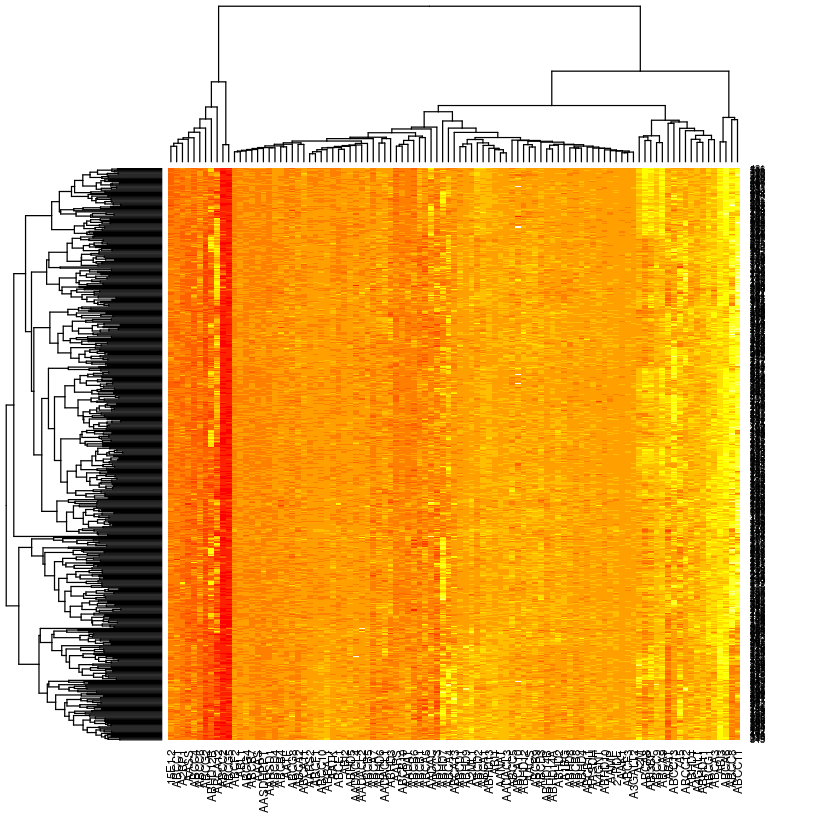

In [34]:
heatmap(as.matrix(filter(brca, tumor)[, 2:100]))

## (Interactive) Challenge Problem
Develop something that classifies breast cancer vs. normal patients on the basis of gene expression data.

Regression?

In [35]:
dim(brca)

[1]   590 17816

We have more predictors (17816) than observations (590), so ordinary regression won't work. Instead, we will try something called *penalized regression*. The idea (very loosely speaking) of penalized regression is to assume that most of the regression coefficients are zero. Thus, although we have 17816 predictors, maybe only 50-100 of them actually affect the outcome. Then, we can hope to do estimation.

In [61]:
library(glmnet)
X <- as.matrix(brca[, 2:(ncol(brca)-1)])
X <- X[, !colSums(!is.finite(X))]  # remove missing values
dim(X)
y <- brca$tumor
cvg <- cv.glmnet(X, y, family="binomial", type.measure="class")

[1]   590 17280

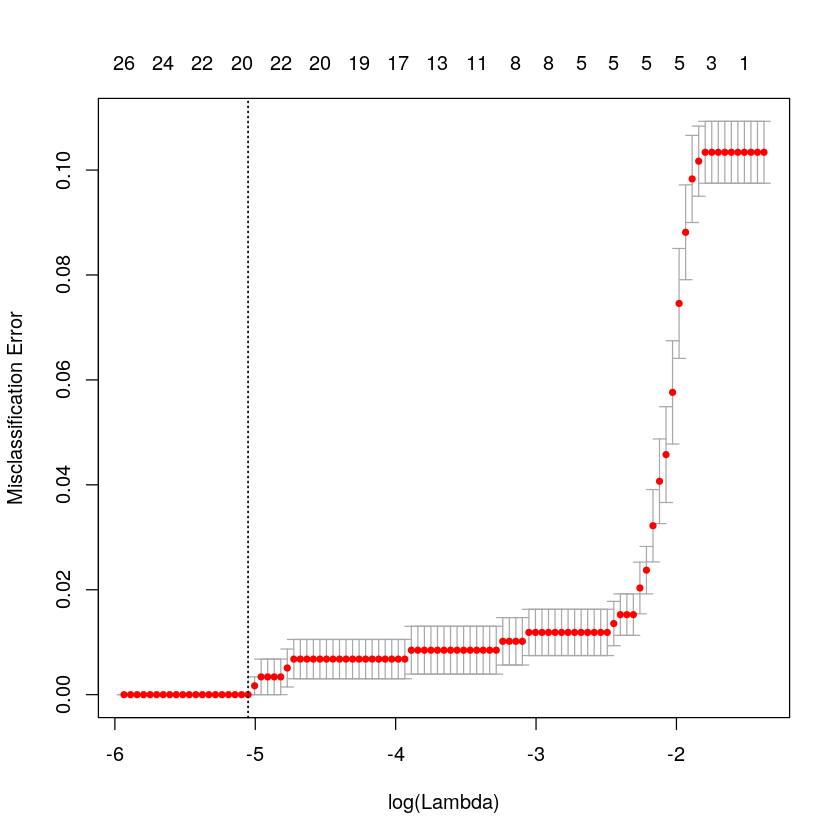

In [62]:
plot(cvg)

In [63]:
cc <- coef(cvg$glmnet.fit, s=cvg$lambda.1se)
rownames(cc)[which(cc!=0)]

[1] "(Intercept)" "ADAM33"      "ADAMTS5"     "ADH4"        "CA4"        
 [6] "CDH12"       "CES1"        "COL10A1"     "HHATL"       "HS3ST4"     
[11] "HSPB6"       "IGSF10"      "KCNE1"       "LRRC3B"      "LRRTM2"     
[16] "MEG3"        "MMP11"       "PAFAH1B3"    "TRPM3"       "WDR51A"     
[21] "WISP1"

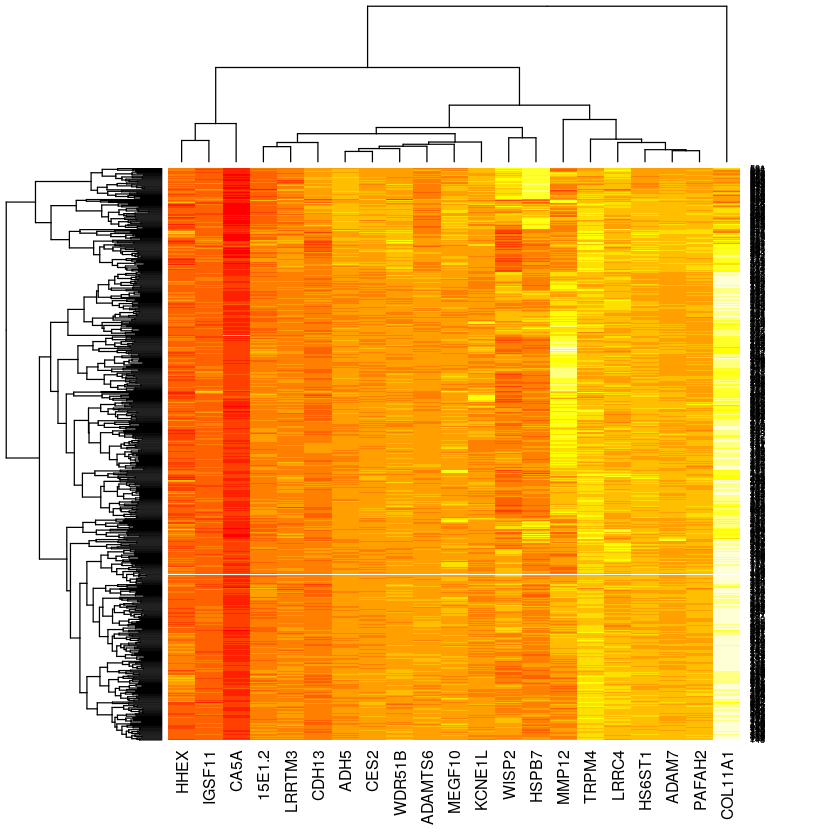

In [65]:
heatmap(X[, which(cc != 0)])

In [75]:
load(url("http://web.stanford.edu/~hastie/glmnet/glmnetData/Leukemia.RData"))
X <- Leukemia$x
y <- Leukemia$y
set.seed(1)

In [77]:
cvg <- cv.glmnet(X,y,family = "binomial", type.measure = "class")
lambda.opt <- cvg$lambda.1se
cc <- coef(cvg, s=lambda.opt)

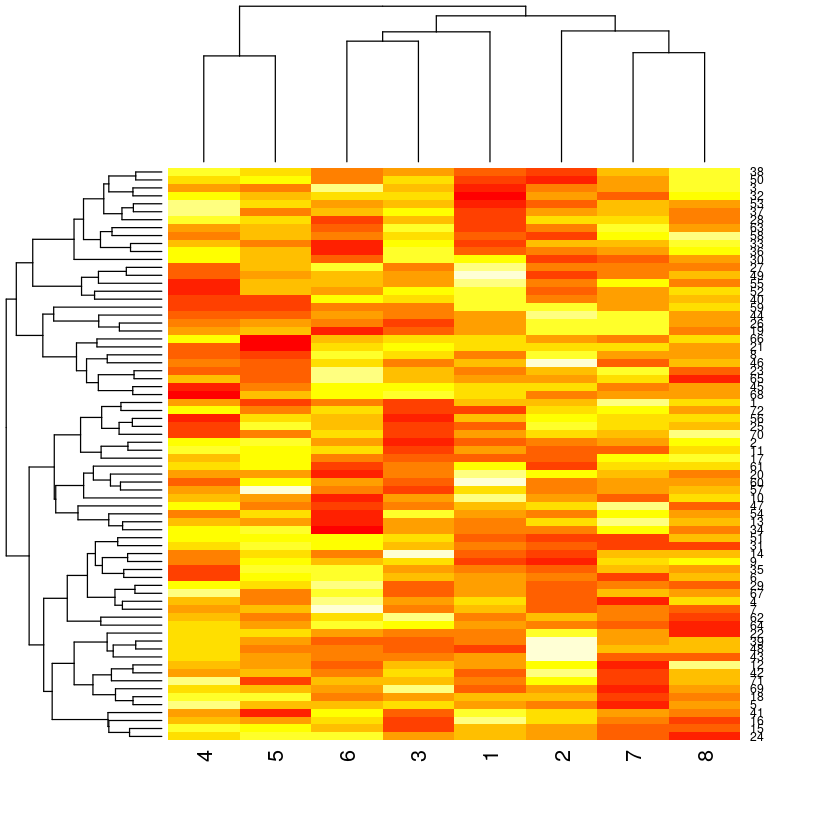

In [78]:
heatmap(X[, which(cc != 0)])

In [79]:
?heatmap